In [249]:
import sys
sys.path.append('..')

import os
import numpy as np
import tifffile as tf
import ntpath
import matplotlib.pyplot as plt
import time
import math
import csv
import seaborn as sns

from utils.gsheets_importer import gsheet2df, correct_behaviour_df
from utils.paq2py import *
from utils.parse_markpoints import ParseMarkpoints
from utils.utils_funcs import *

from random import randint
from scipy import stats

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
sns.set()
sns.set_style('whitegrid')
#%matplotlib notebook

In [250]:
# spreadsheet settings

#the name of the file path column
t_series_header = 'Path (file or folder)'
paq_header = '.paq file'
naparm_header = 'NAPARM path'

#column telling whether to analyse or not
suite2p_bool_header = 'Suite2p_me'

In [251]:
sheet_ID = '1PgSXs6BVHe9dACWEydykucN74rirNfOY4Vr_AmLcCdY'
mouse_name = 'RL042'
date = '2019-05-15_'
SHEET_NAME = date + mouse_name + '!A3:Z100'

df = gsheet2df(sheet_ID, HEADER_ROW=2, SHEET_NAME=SHEET_NAME)
df

,"Type? (a, s, t, z, c)",FOV #,Notes,Path (file or folder),λ/ filter,PV/ LED,~FPS,Frame AVG/ binning,# Frames,Zoom,...,NAPARM path,groups x cells,mW/cell,stim dur (reps x spiral ms),spiral dia (um),inter-stim (ms),trial int (s),Rate (Hz),Amplitude (V),Suite2p_me
0,t,1,"S1_B2 record, B2 whisker stim 100 trials. 512x...","""E:\Data\sarmstrong\2019-05-15\RL042\2019-05-1...",920,220-270-350,30,1,33162(11054),2,...,,,,,,,,10,5,TRUE
1,t,1,"S1_B2 record, B2 whisker stim 100 trials. 1024...","""E:\Data\sarmstrong\2019-05-15\RL042\2019-05-1...",920,220-270-350,15,1,16710 (5570),0.83,...,,,,,,,,10,5,TRUE
2,t,2,"S2_B2 record, B2 whisker stim 100 trials. 512x...","""E:\Data\sarmstrong\2019-05-15\RL042\2019-05-1...",920,220-270-350,30,1,33162(11054),2,...,,,,,,,,10,5,TRUE
3,t,2,"S2_B2 record, B2 whisker stim 100 trials. 1024...","""E:\Data\sarmstrong\2019-05-15\RL042\2019-05-1...",920,220-270-350,15,1,16710(5570),0.83,...,,,,,,,,10,5,TRUE


In [252]:
analyse_idx = df.index[df[suite2p_bool_header]=='TRUE']
tseries_paths = [df.loc[idx,t_series_header] for idx in analyse_idx]
paq_paths = [df.loc[idx,paq_header] for idx in analyse_idx]
sampling_rates = [df.loc[idx,'~FPS'] for idx in analyse_idx]
zoom = [df.loc[idx,'Zoom'] for idx in analyse_idx]
# naparm_paths = [df.loc[idx,naparm_header] for idx in analyse_idx]

print(tseries_paths)
print(paq_paths)
print(sampling_rates)
print(zoom)

['"E:\\Data\\sarmstrong\\2019-05-15\\RL042\\2019-05-15_t-003\\"', '"E:\\Data\\sarmstrong\\2019-05-15\\RL042\\2019-05-15_RL042_B2_t-005\\"', '"E:\\Data\\sarmstrong\\2019-05-15\\RL042\\2019-05-15_RL042_B2_t-006\\"', '"E:\\Data\\sarmstrong\\2019-05-15\\RL042\\2019-05-15_RL042_B2_t-009\\"']
['"E:\\Data\\sarmstrong\\2019-05-15\\RL042\\2019-05-15_RL042_B2_t003.paq"', '"E:\\Data\\sarmstrong\\2019-05-15\\RL042\\2019-05-15_RL042_B2_t005.paq"', '"E:\\Data\\sarmstrong\\2019-05-15\\RL042\\2019-05-15_RL042_B2_t006.paq"', '"E:\\Data\\sarmstrong\\2019-05-15\\RL042\\2019-05-15_RL042_B2_t009.paq"']
['30', '15', '30', '15']
['2', '0.83', '2', '0.83']


In [253]:
def path_conversion(path_list, packerstation_path):
    
    '''converts local paths on 2p imaging computer to packerstation paths
       only works with data arrangement as of 2019-03-27 will likely break in the future
    '''
    
    p = path_list[0]
    name = p.split('\\')[2]
    date = p.split('\\')[3]
    
    local_path = os.path.join(packerstation_path, name, 'Data', date)
    
    converted_paths = [os.path.join(local_path, *p.split('\\')[4:]) for p in path_list]
    #get rid of weird quote marks
    converted_paths = [p.replace('"', '') for p in converted_paths]
    
    return converted_paths

In [254]:
packerstation_path = r"P:\\"

tseries_pstation = path_conversion(tseries_paths, packerstation_path)
paqs_pstation = path_conversion(paq_paths, packerstation_path)
# naparms_pstation = path_conversion(naparm_paths)

print(tseries_pstation)
print(paqs_pstation)

['P:sarmstrong\\Data\\2019-05-15\\RL042\\2019-05-15_t-003\\', 'P:sarmstrong\\Data\\2019-05-15\\RL042\\2019-05-15_RL042_B2_t-005\\', 'P:sarmstrong\\Data\\2019-05-15\\RL042\\2019-05-15_RL042_B2_t-006\\', 'P:sarmstrong\\Data\\2019-05-15\\RL042\\2019-05-15_RL042_B2_t-009\\']
['P:sarmstrong\\Data\\2019-05-15\\RL042\\2019-05-15_RL042_B2_t003.paq', 'P:sarmstrong\\Data\\2019-05-15\\RL042\\2019-05-15_RL042_B2_t005.paq', 'P:sarmstrong\\Data\\2019-05-15\\RL042\\2019-05-15_RL042_B2_t006.paq', 'P:sarmstrong\\Data\\2019-05-15\\RL042\\2019-05-15_RL042_B2_t009.paq']


In [278]:
# choose the files to be analysed
df_index = 0 # index from the pandas dataframe populated by Google sheets, index of the file to be analysed
num_planes = 3
plane = 1 #zero-indexed

# the path to your paq file
paq_path = paqs_pstation[df_index]

# the path to the umbrella suite2p file
s2p_path = os.path.join(tseries_pstation[df_index], 'suite2p', 'plane' + str(plane))
print(s2p_path)

# change this to the name of the paq channel that the stim times was recorded on
stim_name = 'piezo_stim'

P:sarmstrong\Data\2019-05-15\RL042\2019-05-15_t-003\suite2p\plane1


In [279]:
paq = paq_read(paq_path)
raw, stat = s2p_loader(s2p_path, subtract_neuropil=False)

#arr = dfof(raw)
arr = raw
num_units = arr.shape[0]

arr.shape

(337, 11054)

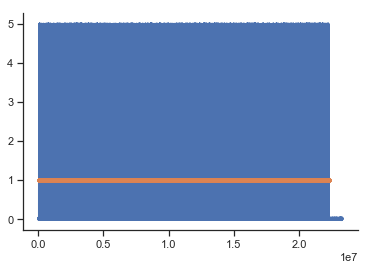

In [280]:
#you might need to run these cells twice to the get the plots for some reason

clock_idx = paq['chan_names'].index('frame_clock')
clock_voltage = paq['data'][clock_idx, :]

frame_clock = threshold_detect(clock_voltage, 1)
plt.figure()
plt.plot(clock_voltage)
plt.plot(frame_clock, np.ones(len(frame_clock)), '.')
sns.despine()
plt.show()

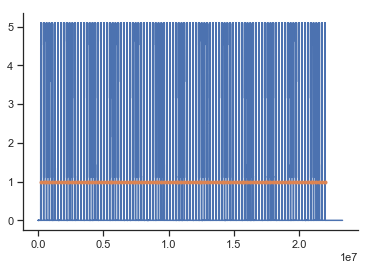

In [281]:
stim_idx = paq['chan_names'].index(stim_name)
stim_volts = paq['data'][stim_idx, :]
stim_times = threshold_detect(stim_volts, 1)

#correct this based on txt file
duration_ms = 1000 #duration of the stim
frame_rate = int(sampling_rates[df_index])/num_planes
duration_frames = np.ceil((duration_ms/1000)*frame_rate)
duration_frames = int(duration_frames)

plt.figure()
plt.plot(stim_volts)
plt.plot(stim_times, np.ones(len(stim_times)), '.')
sns.despine()
plt.show()

In [282]:
stim_start_frames = []

for stim in stim_times:

    #the index of the frame immediately preceeding stim
    stim_start_frame = next(i-1 for i,sample in enumerate(frame_clock[plane::num_planes]) if sample - stim >= 0)
    stim_start_frames.append(stim_start_frame)
    
stim_start_frames = np.array(stim_start_frames)

#sanity check
assert max(stim_start_frames) < arr.shape[1]*num_planes

In [291]:
#this is the key parameter for the sta, how many frames before and after the stim onset do you want to use
pre_frames = 30
post_frames = 30

#list of cell pixel intensity values during each stim on each trial
all_trials = [] # list 1 = cells, list 2 = trials, list 3 = dff vector

# the average of every trial
stas = [] # list 1 = cells, list 2 = sta

sta_amplitudes = []

t_tests = []
wilcoxons = []

#loop through each cell
for i, unit in enumerate(arr):

    trials = []
    amplitudes = []
    df = []
    
    # a flat list of all observations before stim occured
    pre_obs = []
    # a flat list of all observations after stim occured
    post_obs = []
    
    for stim in stim_start_frames:
        
        # get baseline values from pre_stim
        pre_stim_f  = unit[stim-pre_frames : stim]
        baseline = np.mean(pre_stim_f)

        # the whole trial and dfof using baseline
        trial = unit[stim-pre_frames : stim+post_frames]
        trial = [((f-baseline)/ baseline) * 100 for f in trial] #dff calc
        trials.append(trial)

        pre_stim  = trial[ : pre_frames-1]
        post_stim = trial[pre_frames : ]

        #calc amplitude of response        
        pre_f = trial[pre_frames - duration_frames : pre_frames]
        pre_f = np.mean(pre_f)
        post_f = trial[pre_frames + 1 : pre_frames + duration_frames]
        post_f = np.mean(post_f)
        amplitude = post_f - pre_f
        amplitudes.append(amplitude)
        
        # append to flat lists
        pre_obs.append(pre_f)
        post_obs.append(post_f)

        
    trials = np.array(trials)
    all_trials.append(trials)
    
    #average amplitudes across trials
    all_amplitudes = np.array(amplitudes)
    sta_amplitude = np.mean(all_amplitudes,0)
    sta_amplitudes.append(sta_amplitude)

    #average across all trials
    sta = np.mean(trials, 0)        
    stas.append(sta)
    
    #remove nans from flat lists
    pre_obs = [x for x in pre_obs if ~np.isnan(x)]
    post_obs = [x for x in post_obs if ~np.isnan(x)]
    
    #t_test and man whit test pre and post stim (any other test could also be used here)
    t_test = stats.ttest_rel(pre_obs, post_obs)
    t_tests.append(t_test)
    
    wilcoxon = stats.wilcoxon(pre_obs, post_obs)
    wilcoxons.append(wilcoxon)

stas = np.array(stas)
all_trials = np.array(all_trials)   
t_tests = np.array(t_tests)
wilcoxons = np.array(wilcoxons)

In [292]:
#set this to true if you want to multiple comparisons correct for the number of cells
multi_comp_correction = True
if not multi_comp_correction: 
    divisor = 1
else:
    divisor = num_units

In [294]:
p_vals = [t[1] for t in wilcoxons]
idx = range(len(p_vals))

if multi_comp_correction:
    print('performing t-test on cells with mutliple comparisons correction')
else:
    print('performing t-test on cells without mutliple comparisons correction')
    
count = 0
sig_units = []
for p,i in sorted(zip(p_vals,idx)):
    if p < (0.05 / divisor):
        count += 1
        unit_index = stat[i]['original_index']
        print('stimulation has significantly changed fluoresence of s2p unit {}, its P value is {}'.format(unit_index, p))
        sig_units.append(i) #significant units

performing t-test on cells with mutliple comparisons correction
stimulation has significantly changed fluoresence of s2p unit 236, its P value is 7.117077537219983e-18
stimulation has significantly changed fluoresence of s2p unit 144, its P value is 9.893009181510365e-18
stimulation has significantly changed fluoresence of s2p unit 179, its P value is 2.483725635893387e-17
stimulation has significantly changed fluoresence of s2p unit 410, its P value is 2.5581057720235416e-17
stimulation has significantly changed fluoresence of s2p unit 42, its P value is 2.8782421504419467e-17
stimulation has significantly changed fluoresence of s2p unit 47, its P value is 3.14398699044227e-17
stimulation has significantly changed fluoresence of s2p unit 516, its P value is 4.2169267302822515e-17
stimulation has significantly changed fluoresence of s2p unit 198, its P value is 6.729249235397462e-17
stimulation has significantly changed fluoresence of s2p unit 352, its P value is 8.998385137455785e-17


In [290]:
# save the sta amplitudes from significantly different cells
sig_amplitudes = [sta_amplitudes[i] for i in sig_units]

np.save(s2p_path + '_sig_sta_amplitudes.npy', sig_amplitudes)

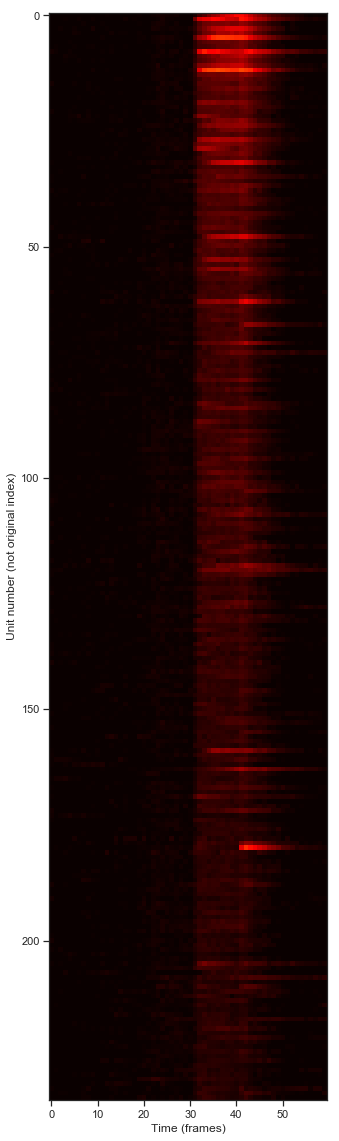

In [303]:
# # Plot all units on same graph (good for 20-50 units)
# plt.figure(figsize=(5,10))

# for i,unit in enumerate(sig_units):
#     line_offset = i*20
    
#     unit_index = stat[i]['original_index']
    
#     x_axis = (np.arange(len(sta)) - pre_frames) / frame_rate

#     sta = stas[unit]
#     [plt.plot(x_axis, t - line_offset, c='grey', alpha=0.2) for t in all_trials[unit,:,:]]
#     plt.plot(x_axis, sta - line_offset)
#     plt.title('Unit ' + str(unit_index))
#     plt.xlabel('Time (seconds)')
#     plt.ylabel('DFoF (%)')
#     #plt.ylim((-100,200))
#     sns.despine()

# # Plot all units on individual graphs (good for 10-20 units)
# for i,unit in enumerate(sig_units):
#     plt.figure()
#     unit_index = stat[i]['original_index']
    
#     x_axis = (np.arange(len(sta)) - pre_frames) / frame_rate

#     sta = stas[unit]
#     [plt.plot(x_axis, t, c='grey', alpha=0.2) for t in all_trials[unit,:,:]]
#     plt.plot(x_axis, sta)
#     plt.title('Unit ' + str(unit_index))
#     plt.xlabel('Time (seconds)')
#     plt.ylabel('DFoF (%)')
#     #plt.ylim((-100,200))
#     sns.despine()

# # Plot user-defined unit (good for visualising individual units of 100s)
# plt.figure()
# unit = 180
# sig_unit = sig_units[unit]
# unit_index = stat[sig_unit]['original_index']
    
# x_axis = (np.arange(len(sta)) - pre_frames) / frame_rate

# sta = stas[sig_unit]
# [plt.plot(x_axis, t, c='grey', alpha=0.2) for t in all_trials[sig_unit,:,:]]
# plt.plot(x_axis, sta)
# plt.title('Unit ' + str(unit_index))
# plt.xlabel('Time (seconds)')
# plt.ylabel('DFoF (%)')
# # plt.ylim((-100,200))
# sns.despine()

# Plot all units as a heatmap (good for visualising 100s of units)
plt.figure(figsize=(5,20))
sns.set_style('ticks')

heatmap_sta = []

for i in sig_units:
    heatmap_sta.append(stas[i])
    
plt.imshow(heatmap_sta, cmap='hot', vmin=0, vmax=100, interpolation='nearest')

plt.xlabel('Time (frames)')
plt.ylabel('Unit number (not original index)')
plt.show()

Text(0, 0.5, 'Difference in amplitude post-pre stim (%)')

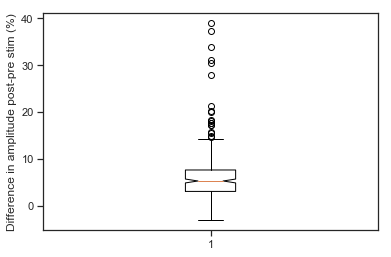

In [308]:
# retrieve all amplitudes and plot distribution

path = r'P:\sarmstrong\Data\2019-05-15\RL042\2019-05-15_t-003\suite2p'

all_amplitudes = []

for dirpath, dirnames, filenames in os.walk(path):
    
    for file in filenames:
        if 'amplitudes' in file:
            amplitudes = np.load(os.path.join(path, file))
            all_amplitudes.append(amplitudes)
        
all_amplitudes = [amplitude for amplitudes in all_amplitudes for amplitude in amplitudes]

plt.figure
plt.boxplot(all_amplitudes, notch=True);
plt.ylabel('Difference in amplitude post-pre stim (%)')
# sns.distplot(all_amplitudes, bins=20)
# plt.axis([-100, 500, 0, 0.085])
# plt.savefig(r'C:\Users\roble\Documents\Packer lab\Analysis\Whisker stim\Suite2p\Good GCaMP\Whisker stim response amplitudes.svg')